In [288]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from IPython.display import Image, display, Markdown
from PIL import Image as PILImage
from scipy import stats
from tqdm import tqdm
from helpers import *

# initialize tqdm for pandas
tqdm.pandas()
# turn off the SettingWithCopyWarning
pd.options.mode.chained_assignment = None
# turn off warnings
import warnings
warnings.filterwarnings('ignore')

# define path
DIR = ".\\data\\raw"
PATH_DF_CHANNELS = DIR + '\\df_channels_en.tsv.gz'
PATH_DF_TIMESERIES = DIR + '\\df_timeseries_en.tsv.gz'
PATH_YT_METADATA = DIR + '\\yt_metadata_en.jsonl.gz'
PATH_NUM_COMMENTS = DIR  + '\\num_comments.tsv.gz'

In this notebook we want to focus on the analysis of tech review channels to understand what are the main factors of success for the YouTubers in this category.

The analysis is divided into the following parts:
1. Preprocessing (filtering the tech review channels)
2. Characteristics of successful channels
    - Video duration
    - Upload frequency
    - Range of tech products
3. Viewers reaction to big tech product releases

## Preprocessing

For filtering the tech review channels we are using the following method, we are first creating 2 lists with the words used in tags and titles of the videos of the most popular Tech Review YouTubers, and using these 2 lists to classify all the videos (in "Education" and "Science and Technology" categories only) to tech review videos. Then, we are classifying the channels into tech review channels depending on what fraction of all of their videos are about tech review.

In [6]:
# filter metadata only considering the videos in "Education" and "Science & Technology"
dfs = []
total_rows = 72924794
chunksize = 100000
for df_json in tqdm(pd.read_json(PATH_YT_METADATA, compression="infer", lines=True, chunksize=chunksize), desc='Loading data', total=total_rows/chunksize):
    df_json = df_json[['channel_id','display_id','duration','tags','title','categories']]
    df_json = df_json[(df_json['categories'] == 'Education') | (df_json['categories'] == 'Science & Technology')]
    
    dfs.append(df_json)
df_tech = pd.concat(dfs)
df_tech.drop('categories',axis=1,inplace=True)

# some videos don't define and tag, so we set them to an empty string
df_tech['tags'].fillna('',inplace=True)


# select the videos of the most popular tech review channels
df_channels = pd.read_csv(PATH_DF_CHANNELS, compression="infer", sep="\t")

popular_tech_channels = ['Marques Brownlee','Mrwhosetheboss','iJustine','UrAvgConsumer',
                         'Unbox Therapy','Linus Tech Tips','The Tech Chap','MrMobile [Michael Fi...']
popular_tech_channels_id = df_channels[df_channels.name_cc.isin(popular_tech_channels)].channel.unique()
df_tech_pop = df_tech[df_tech.channel_id.isin(popular_tech_channels_id)][['tags','title']]


# Find the most commonly used words both in tags and titles of the above videos
print('Cleaning title')
df_tech_pop['clean_title'] = df_tech_pop.title.progress_apply(clean_text)
print('Cleaning tags')
df_tech_pop['clean_tags'] = df_tech_pop.tags.progress_apply(clean_text)

# create a single list for all the words in both tags and titles
all_tags = []
all_titles = []
for tags in df_tech_pop.clean_tags.values:
    all_tags += tags
for titles in df_tech_pop.clean_title.values:
    all_titles += titles


# clean title and tags of all the videos
df_tech_review = df_tech.copy()
print('Cleaning all titles')
df_tech_review['clean_title'] = df_tech_review.title.progress_apply(clean_text)
print('Cleaning all tags')
df_tech_review['clean_tags'] = df_tech_review.tags.progress_apply(clean_text)

Loading data: 730it [30:12,  2.48s/it]                               


Cleaning title


100%|██████████| 10234/10234 [00:17<00:00, 596.64it/s]


Cleaning tags


100%|██████████| 10234/10234 [00:49<00:00, 205.00it/s]


Cleaning all titles


100%|██████████| 6198568/6198568 [2:25:31<00:00, 709.94it/s]  


Cleaning all tags


100%|██████████| 6198568/6198568 [8:35:16<00:00, 200.49it/s]    


To classify the videos into tech review, we are using the following method:


First, we get the 100 most commonly used words in the titles of the videos of the most popular tech review youtubers on youtube (call it TITLES_COMMON). Then, for each video calculate what percentage of the words used in their titles occurs in TITLES_COMMON, and we repeat this proces for tags as well. Finally, if the duration of the video is less than 20 minutes, and at least 50% of the words used either in its title or tags are the ones used in TITLES_COMMON, or TAGS_COMMON, then we set this video as "tech review".

As we are selecting only the 100 most commonly used words, it may not be a perfect classification algorithm, but for the sake of this milestone, we decided to move on with the analysis with this method. We also have implemented 2 other methods (in the [helpers.py](.\\helpers.py) scritp) that are about TF-IDF, and Bayesian classifier. We will briefly discuss the methods here, and implement and explore them in the next milestone.

**1st method:**

We chose the top well-known tech YouTubers and took all titles of their videos and split titles into lists of tokens (call it CORPUS). For every token we compute its TF-IDF $\frac{\text{{\# occurrences}}}{\text{{\# size of all titles}}} \times \log\left(\frac{\text{{\# titles}}}{\text{{\# titles in which token appears}}}\right)$ Having a dictionary of TF-IDF score for each token, we compute the score of each title (of all videos) by summing up the coefficients of its tokens if present in the CORPUS or 0 if not. Finally, we set the video as “tech review”, depending on its score.

**2nd method:**

We first need to form a "dict_good" python dict containing, as keys, all words from the tech review videos' titles (smoothed; i.e. we add to it all words that aren't initially in it but are among words in all titles when considering all videos) and, containing as values, the frequency of the word (probability; i.e. $ \frac{\text{{\# of occurences of the word}}}{(\text{{\# of occurences of all words + smoothing factor*N}}))} $; for words that weren't initially present, we assign to them: $ \frac{smoothing factor}{(\# of occurences of all words + smoothing factor*N)} $. Smoothing factor is chosen to be 1. N is the number of words that are added (initially not among the words from the titles of tech review videos). We also need to feed in a second argument: "dict_bad": same idea as "dict_good", but contains all other words that aren't in the titles of tech review videos (also smoothed). The 3rd argument is the title: list of the words of the title of a video to which we want to get its score. The score is the conditional proba: $ P(\text{good} | \text{title}) $ Then we compare the title's score to 0.5, if it's larger then it's likely "good" else it's considered "bad".

**The most occured words in tags**

iphone - review - unboxing - best - tech - galaxy - android - gaming - samsung - apple - pro - smartphone - phone - new - gadget - video - camera - plus - note - unbox - therapy - game - technology - headphone - oneplus - pc - laptop - google - ipad - pixel - cool - computer - beat - unboxtherapy - test - one - wireless - macbook - lg - top - tip - xbox - huawei - case - nexus - sony - setup - hd - battery - youtube - monitor - linus - tv - invention - playstation - asus - bluetooth - speaker - chap - nvidia - uravgconsumer - giveaway - consumer - max - ce - first - htc - mate - tour - xl - mkbhd - intel - gtx - air - apps - overview - smart - watch - card - edge - io - audio - hand - edition - core - keyboard - look - system - budget - build - display - razer - mobile - tablet - average - high - cheap - industry - amazon - nintendo

**The most occured words in titles**

tech - unboxing - tip - linus - first - review - look - gaming - iphone - pc - galaxy - pro - best - new - samsung - hd - chap - show - smartphone - ce - phone - asus - wan - gtx - video - case - overview - android - card - laptop - edition - test - camera - top - apple - one - giveaway - google - core - ultimate - intel - wireless - ijustine - nvidia - motherboard - headphone - monitor - note - amd - drive - corsair - setup - oneplus - keyboard - cpu - lg - geforce - plus - tutorial - performance - hand - impression - part - msi - gb - cooler - mouse - ipad - world - ssd - power - game - huawei - tv - guide - buy - day - macbook - razer - ever - pixel - computer - series - sony - youtube - usb - update - mini - speaker - headset - gadget - window - comparison - tour - beat - nexus - full - gigabyte - life - watch

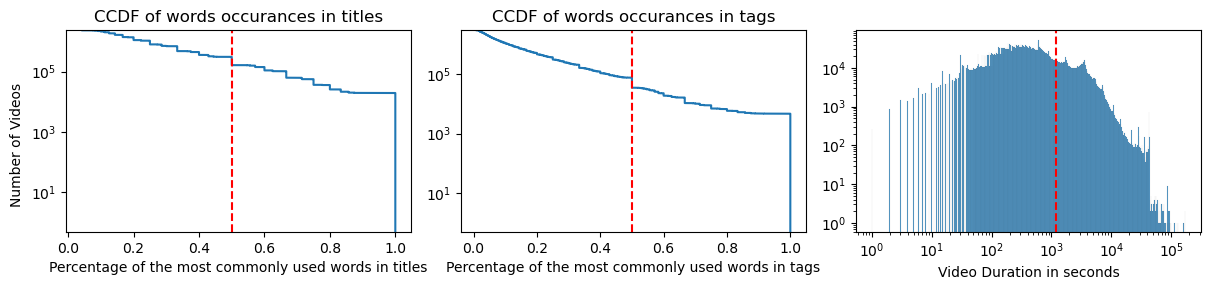

In [8]:
# get 100 most commonly used words in tags and titles of the most popular youtubers
tags_common = get_common_words(all_tags).rename({'word':'tags_unique','occurance':'tags_occurance'},axis=1)
titles_common = get_common_words(all_titles).rename({'word':'titles_unique','occurance':'titles_occurance'},axis=1)

# display the most occured words in tags and titles
markdown_tags = " - ".join(tags_common['tags_unique'].to_list())
markdown_titles = " - ".join(titles_common['titles_unique'].to_list())
display(Markdown('**The most occured words in tags**\n\n' + markdown_tags))
display(Markdown('**The most occured words in titles**\n\n' + markdown_titles))

# count the number of occurances of the above words in the tags/title of each video
df_tech_review['tags_occurances_perc'] = df_tech_review['clean_tags'].apply(lambda tags: 0 if len(tags) == 0 else (np.intersect1d(tags, tags_common['tags_unique'].unique()).shape[0] / len(tags)))
df_tech_review['title_occurances_perc'] = df_tech_review['clean_title'].apply(lambda title: 0 if len(title)==0 else (np.intersect1d(title, titles_common['titles_unique'].unique()).shape[0] / len(title)))

# plot the words distribution to highlight how we are filtering the tech review videos
fig, axes2 = plt.subplots(nrows=1,ncols=3,figsize=(12,3))
sns.ecdfplot(x = df_tech_review[df_tech_review.title_occurances_perc > 0].title_occurances_perc, complementary=True, stat='count', log_scale=(False, True), ax=axes2[0])
sns.ecdfplot(x = df_tech_review[df_tech_review.tags_occurances_perc > 0].tags_occurances_perc, complementary=True, stat='count', log_scale=(False, True), ax=axes2[1])
sns.histplot(x = df_tech_review.duration, stat='count', log_scale=(True, False), ax=axes2[2])
axes2[0].axvline(x=0.5, color='red', linestyle='--')
axes2[1].axvline(x=0.5, color='red', linestyle='--')
axes2[2].axvline(x=1200, color='red', linestyle='--')
axes2[0].set(title='CCDF of words occurances in titles',xlabel='Percentage of the most commonly used words in titles', ylabel=None, yscale='log')
axes2[1].set(title='CCDF of words occurances in tags', xlabel='Percentage of the most commonly used words in tags', ylabel=None, yscale='log')
axes2[2].set(xlabel='Video Duration in seconds', ylabel=None, yscale='log')
fig.text(-0.005, 0.5, 'Number of Videos', va='center', rotation='vertical')
plt.tight_layout()
plt.show()

We filter the videos that have more than 50% of the words of their title or tags are the ones found in the most commongly used words list. Then, we filter the channels that are in Education or Science & Technology category and have more than 5% of their videos in tech review. Note that the category of the channels is assigned by the socialblade platform depending on the last 10 videos published at the time of crawl.

In [9]:
# tech review videos only
df_tech_review_videos = df_tech_review[(df_tech_review.duration < 1200) & ((df_tech_review.tags_occurances_perc > 0.5) | (df_tech_review.title_occurances_perc > 0.5))]

# count the number of tech review videos per channel
count_tech_videos = df_tech_review_videos.groupby('channel_id',as_index=False)[['display_id']].count().rename({'display_id':'count_tech_videos'},axis=1)

# assign the number of tech review videos for each channel
df_tech_channels = pd.merge(df_channels.rename({'channel':'channel_id'},axis=1), count_tech_videos, how='left', on='channel_id')
df_tech_channels.loc[df_tech_channels.count_tech_videos.isna(), 'count_tech_videos'] = 0

# get the percentage of tech review videos
df_tech_channels['tech_videos_perc'] = df_tech_channels['count_tech_videos'] / df_tech_channels['videos_cc']

# tech review videos only
df_tech_review_channels = df_tech_channels[(df_tech_channels.tech_videos_perc > 0.05) & (df_tech_channels.category_cc.isin(['Education','Science & Technology']))].drop(['category_cc','tech_videos_perc'],axis=1).reset_index(drop=True)
display(df_tech_review_channels.sample(5))

,join_date,channel_id,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights,count_tech_videos
406,2014-12-29,UCWVyEdLMP9b6P0FOSkripLQ,TecworkZ,120198,301,131463.0,4.3110,178.0
1212,2010-01-25,UCQT1rbzlJPiwFEBNeDbJDvQ,Andy Rox,11000,77,849534.0,15.3200,7.0
269,2014-09-25,UC_nPskT9hNIUUYE7_pZK5pw,BEST REVIEWS,213000,781,78859.0,3.6855,87.0
1200,2015-09-17,UCBl1nL13BmieYFD9f1ZBS8Q,Arindam Sen,12366,38,834445.0,12.1815,2.0
418,2006-10-17,UCxn2JKjtfOy5qr1pnen79Fw,TigerDirect,114000,4338,136294.0,5.5140,342.0


Now from the youtube videos metadata, we want to filter the tech review channels only, keeping all of their videos from original metadata (both tech and non-tech).

In [10]:
# filter metadata
dfs = []
total_rows = 72924794
chunksize = 100000
for df_json in tqdm(pd.read_json(PATH_YT_METADATA, compression="infer", lines=True, chunksize=chunksize), desc='Loading data', total=total_rows/chunksize):
    df_json.drop(["description", "crawl_date"], inplace=True, axis=1)
    df_json = df_json[df_json.channel_id.isin(df_tech_review_channels.channel_id.unique())]
    df_json["upload_date"] = pd.to_datetime(df_json["upload_date"])
    
    dfs.append(df_json)
df_tech_review_mt = pd.concat(dfs)

# flag tech videos
df_tech_review_mt.loc[df_tech_review_mt.display_id.isin(df_tech_review_videos.display_id.unique()),'tech_review'] = True
df_tech_review_mt.tech_review.fillna(False, inplace=True)

# add number of comments
num_comments = pd.read_csv(PATH_NUM_COMMENTS, compression="infer", sep="\t")
df_tech_review_mt = pd.merge(df_tech_review_mt, num_comments, on='display_id', how='left')

# clean title and tags
print('Cleaning all titles')
df_tech_review_mt['clean_title'] = df_tech_review_mt.title.progress_apply(clean_text)
print('Cleaning all tags')
df_tech_review_mt['clean_tags'] = df_tech_review_mt.tags.progress_apply(clean_text)

Loading data: 730it [32:24,  2.66s/it]                               


Cleaning all titles


100%|██████████| 740018/740018 [16:35<00:00, 743.45it/s] 


Cleaning all tags


100%|██████████| 740018/740018 [1:09:32<00:00, 177.35it/s] 


With that we will be done with preprocessing with 2 datasets in our hand to be used throughout the analysis:
- df_tech_review_channels: Channel Data for tech review channels only
- df_tech_review_mt: Video Meatadata of tech review channels only

# Characteristics of successful channels

### Video duration

Let's start off with the analysis of a video duration. We can take the number of likes and dislikes as metrics of a video. We first want to know if there is any correlation between likes/dislikes and the duration of a video. Below, we are calculating the pearson correlation between the number of like/dislikes and the duration of a video. We decided to do the pearson correlation, as the correlation is linear (to be seen later)

In [142]:
# filter only the tech review videos by tech review channels
df_vd_tech = df_tech_review_mt[df_tech_review_mt.tech_review]
df_vd_tech["upload_date"] = pd.to_datetime(df_vd_tech["upload_date"])
df_vd_tech["upload_year"] = df_vd_tech['upload_date'].dt.year

# correlation between the duration of the video and number of likes and dislikes
df_vd_tech_filtered = df_vd_tech.copy()
# just to avoid division by 0
df_vd_tech_filtered["view_count"] = df_vd_tech_filtered["view_count"].replace({0:1})
#correlation between like count and duration
df_vd_tech_filtered["like_count_ratio"] = df_vd_tech_filtered['like_count']/df_vd_tech_filtered["view_count"]
df_vd_tech_filtered["dislike_count_ratio"] = df_vd_tech_filtered['dislike_count']/df_vd_tech_filtered["view_count"]
pearson_like_duration_corrs = []
pearson_dislike_duration_corrs = []

years = np.unique(df_vd_tech_filtered["upload_year"])
for year in years:
    #compute pearson correlation
    df = df_vd_tech_filtered[df_vd_tech_filtered["upload_year"]==year].dropna()
    corr_like = stats.pearsonr(df["duration"], df['like_count_ratio'])
    corr_dislike = stats.pearsonr(df["duration"], df['dislike_count_ratio'])
    pearson_like_duration_corrs.append(corr_like)
    pearson_dislike_duration_corrs.append(corr_dislike)

df_corrs_pearson_like = pd.DataFrame(pearson_like_duration_corrs, columns=["pearson_corr", "p_value"], index=years)
df_corrs_pearson_dislike = pd.DataFrame(pearson_dislike_duration_corrs, columns=["pearson_corr", "p_value"], index=years) 

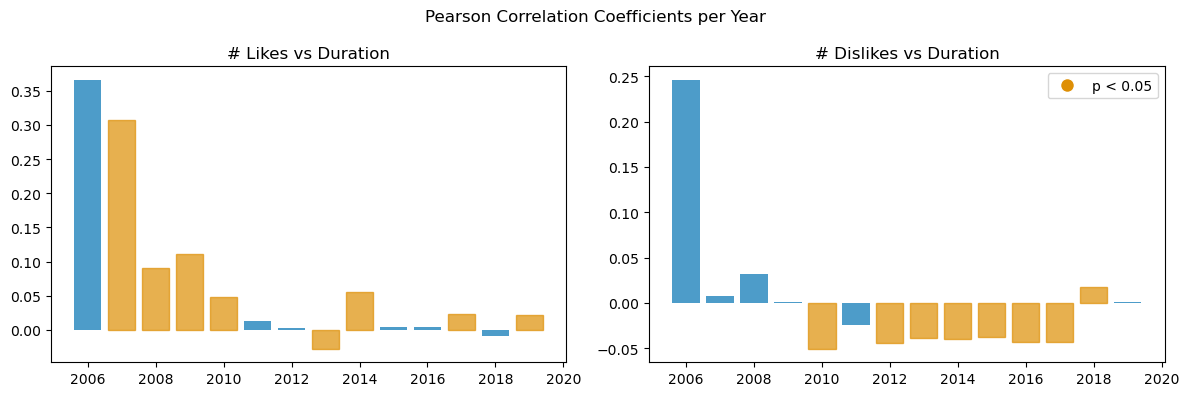

In [147]:
colors = sns.color_palette("colorblind",2)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Create a bar plot for Pearson correlation coefficients
bar_like = axs[0].bar(df_corrs_pearson_like.index, df_corrs_pearson_like["pearson_corr"], color=colors[0], alpha=0.7)
bar_dislike = axs[1].bar(df_corrs_pearson_dislike.index, df_corrs_pearson_dislike["pearson_corr"], color=colors[0], alpha=0.7)

# Highlight bars where p-values are less than 0.05
for bar, p_value in zip(bar_like, df_corrs_pearson_like["p_value"]):
    if p_value < 0.05:
        bar.set_color(colors[1])
for bar, p_value in zip(bar_dislike, df_corrs_pearson_dislike["p_value"]):
    if p_value < 0.05:
        bar.set_color(colors[1])

# Set labels and title
axs[0].set_title('# Likes vs Duration')
axs[1].set_title('# Dislikes vs Duration')

# Display a legend indicating significance
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[1], markersize=10, label='p < 0.05')],
           loc='upper right')
plt.suptitle('Pearson Correlation Coefficients per Year')
plt.tight_layout()
plt.show()

There is a relatively high positive correaltion (that is decreasing across the years), but significant (p_value < 0.05) between the duration of a video and the number of likes it gets. This is different from causation (i.e this does NOT mean that by uploading a longer video we will get more likes) but this nonetheless means that with longer videos we tend to have a bigger number of likes. 

We can assume it is because over the years YouTube has become a popular platform, attracting more users, and therefor likes as well. Let's see the trend of likes, dislikes, and the duration further to be able to come to better conclusion:

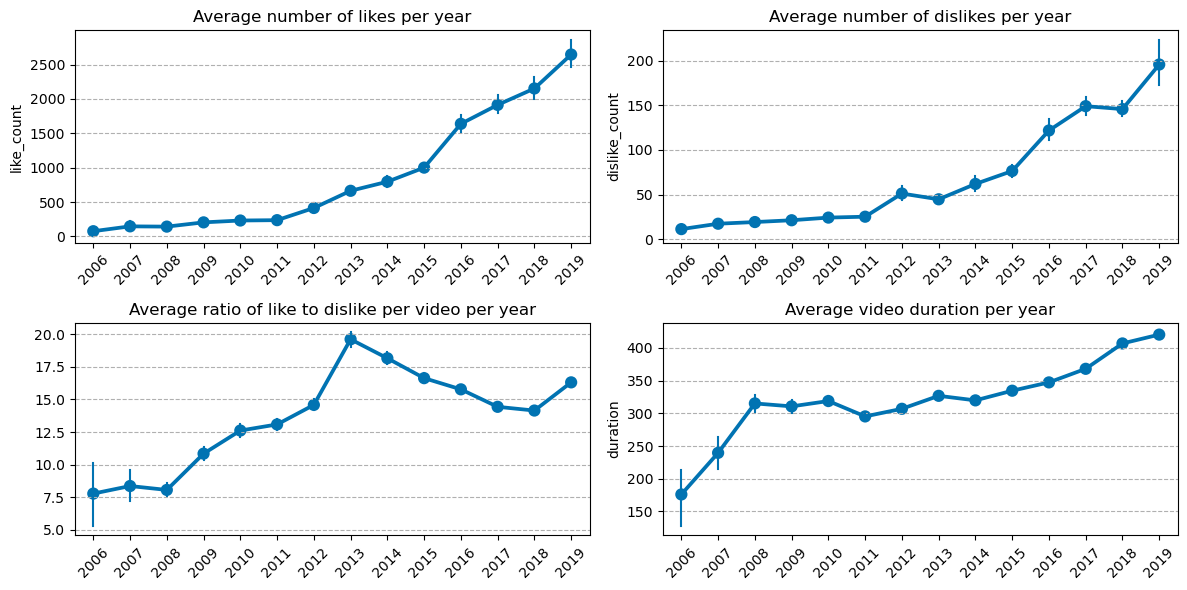

In [144]:
# just to avoid division by 0
df_vd_tech['dislike_count'] = df_vd_tech['dislike_count'].replace({0:1})

color = sns.color_palette("colorblind",1)
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))

sns.pointplot(x=df_vd_tech['upload_year'],
              y=df_vd_tech['like_count'],
              errwidth=1.5,
              color=color[0],
              ax=axs[0][0])

sns.pointplot(x=df_vd_tech['upload_year'],
              y=df_vd_tech['dislike_count'],
              errwidth=1.5,
              color=color[0],
              ax=axs[0][1])
sns.pointplot(x=df_vd_tech['upload_year'],
              y=df_vd_tech['like_count'] / df_vd_tech['dislike_count'],
              errwidth=1.5,
              color=color[0],
              ax=axs[1][0])
sns.pointplot(x=df_vd_tech['upload_year'],
              y=df_vd_tech['duration'],
              errwidth=1.5,
              color=color[0],
              ax=axs[1][1])

axs[0][0].set(title='Average number of likes per year', xlabel=None)
axs[0][0].grid(axis='y', linestyle='--')
axs[0][0].tick_params(axis='x', rotation=45)

axs[0][1].set(title='Average number of dislikes per year', xlabel=None)
axs[0][1].grid(axis='y', linestyle='--')
axs[0][1].tick_params(axis='x', rotation=45)

axs[1][0].set(title='Average ratio of like to dislike per video per year', xlabel=None)
axs[1][0].grid(axis='y', linestyle='--')
axs[1][0].tick_params(axis='x', rotation=45)

axs[1][1].set(title='Average video duration per year', xlabel=None)
axs[1][1].grid(axis='y', linestyle='--')
axs[1][1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

We see from the above plot that both number of dislikes and likes have been increasing across the years. Multiple reasons can justify this: for instance this could be due to more users on the platform or more user engagement (users engage with the content and give their opinion which can be positive or negative, instead of saying nothing).

We can also see that the length of youtube videos has been increasing over the years: it went from 200 seconds (~3.3 minutes) in 2006 to more than 400 seconds (~6.6 minutes) in 2019 on average. This can be explained by the various technological advancements (bigger memory space to store and upload the videos, better camera battery, camera portability, etc), and to the higher creativity youtubers have to film longer videos that have more content.

However, much higher increase rate of number of likes compared to the one of dislikes can explain the correlations we had in the previous plots. Namely, why we had higher correaltion between Likes and Duration, and less correlation between Dislikes and Duration.


Let's now see how the video duration is related to a user engagement. We do it by plotting the moving average of likes to dislikes ratio over the duration of a video.

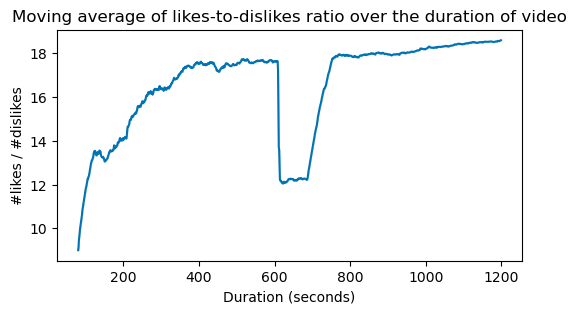

In [145]:
# get the likes to dislikes ratio
df_vd_tech_ratio = df_vd_tech[['upload_year','like_count','dislike_count','display_id','duration']]
df_vd_tech_ratio['dislike_count'] = df_vd_tech_ratio['dislike_count'].replace({0:1})
df_vd_tech_ratio['dislike_count'].fillna(1,inplace=True)
df_vd_tech_ratio['like_dislike_ratio'] = df_vd_tech_ratio['like_count'] / df_vd_tech_ratio['dislike_count']
df_vd_tech_ratio.like_dislike_ratio.fillna(0,inplace=True)
df_vd_tech_ratio.sort_values(by='duration',inplace=True)

# plot moving average of likes to dislikes ratio versus duration
color = sns.color_palette("colorblind",1)
plt.figure(figsize=(6,3))
y = df_vd_tech_ratio["like_dislike_ratio"].rolling(10000).mean().values
x = df_vd_tech_ratio['duration']
ax = sns.lineplot(x=x, y=y, color=color[0])
ax.set(title='Moving average of likes-to-dislikes ratio over the duration of video', xlabel='Duration (seconds)', ylabel='#likes / #dislikes')
plt.show()

We can see from this plot that generally the longer videos (up to 20m) tend to be liked more by the users, except for the video between 10 - 11 minutes. This could be because of an enormous number of videos on YouTube with this duration, which might include a lot of low quality videos as well, as people usually try to produce videos around 10 minutes. We may of course further analyse it in the next milestone! 

### Upload frequency

In this section we want to see the relationship between the frequency of releasing a video with the growth of number of subscribers. We first start by calculating the macro average of time delay (in days) between 2 consequtive videos per channel.

In [261]:
# define average upload frequency per channel
tech_mt_uf = df_tech_review_mt.copy()
tech_mt_uf['upload_date'] = pd.to_datetime(tech_mt_uf.upload_date)
tech_mt_uf.sort_values(by=['channel_id','upload_date'],ascending=True,inplace=True)
tech_mt_uf['delay'] = tech_mt_uf.upload_date - tech_mt_uf.shift(1).upload_date
# set all first uploads to 0
first_upload = tech_mt_uf.groupby('channel_id',as_index=False)[['upload_date']].min()
first_upload['is_first'] = True
tech_df_upload_freq = pd.merge(tech_mt_uf,first_upload,on=['channel_id','upload_date'],how='left')
tech_df_upload_freq.is_first.fillna(False,inplace=True)
tech_df_upload_freq.loc[tech_df_upload_freq.is_first,'delay'] = pd.Timedelta(seconds=0)
tech_df_upload_freq['upload_year'] = tech_df_upload_freq.upload_date.dt.year
tech_df_upload_freq['upload_month'] = tech_df_upload_freq.upload_date.dt.month
tech_df_avg = tech_df_upload_freq.groupby(['channel_id','upload_year','upload_month'],as_index=False)[['delay']].mean().groupby(['channel_id','upload_year'],as_index=False)[['delay']].mean().groupby(['channel_id'],as_index=False)[['delay']].mean()
tech_df_avg.rename({'delay':'avg_delay'},axis=1,inplace=True)
tech_df_avg.avg_delay = (tech_df_avg.avg_delay / np.timedelta64(1, 'D')).astype(float)

# merge with the channels dataset
tech_chan_freq = pd.merge(df_tech_review_channels[['channel_id','subscribers_cc']],tech_df_avg,on='channel_id',how='left')

# define a new rank to the channels depending on its number of subscribers
tech_chan_freq.sort_values(by='subscribers_cc',ascending=False, inplace=True)
tech_chan_freq['rank'] = pd.Series(range(1, tech_chan_freq.shape[0]+1))

display(tech_chan_freq.head(5))

,channel_id,subscribers_cc,avg_delay,rank
0,UCsTcErHg8oDvUnTzoqsYeNw,15300000,2.109313,1
1,UCOhHO2ICt0ti9KAh-QHvttQ,13979890,0.639003,2
2,UCe_vXdMrHHseZ_esYUskSBw,11200000,2.056179,3
3,UCE_M8A5yxnLfW0KghEeajjw,9970000,27.291717,4
4,UCBJycsmduvYEL83R_U4JriQ,9400000,8.567125,5


Now let's us see the average time delay 10 bins of number of subscribers. In the plot below, every bin is labeled by the largest value in it.

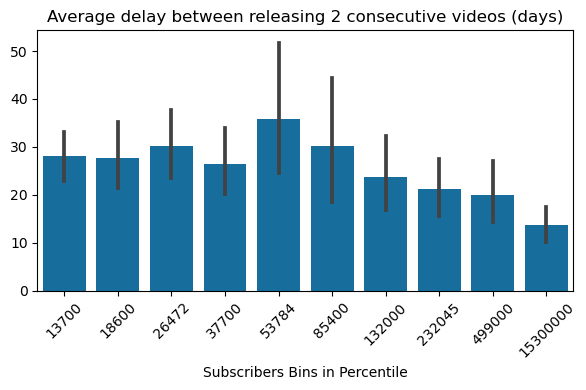

In [183]:
# Create bins based on percentiles
percentiles = np.arange(0, 101, 10)
bin_edges = np.percentile(tech_chan_freq['subscribers_cc'], percentiles)
tech_chan_freq['subscribers_bin_perc'] = pd.cut(tech_chan_freq['subscribers_cc'], bins=bin_edges)

# Calculate maximum values in each bin
max_values_perc = tech_chan_freq.groupby('subscribers_bin_perc')['subscribers_cc'].max().reset_index()

# plot
plt.figure(figsize=(6,4))
colors = sns.color_palette("colorblind", 1)
ax = sns.barplot(x='subscribers_bin_perc', y='avg_delay', data=tech_chan_freq, color=colors[0])
ax.set(ylabel=None, xlabel='Subscribers Bins in Percentile')
# show max number of subscriber in each bin
ax.set_xticklabels(max_values_perc['subscribers_cc'])
ax.tick_params(axis='x', rotation=45)

plt.title('Average delay between releasing 2 consecutive videos (days)')
plt.show()

We can already see some trend that the channels with higher number of subscribers tend to publish more frequently. Let's also see how it is correlated with the rate of subscribers growth.

Below, we are considering only 3 channels for the sake of simplicity. For each of the channels, we are calculating monthly number of videos, average time delay, and number of monthly new subscribers to the total subscribers. We decided here to use relative delta subscribers instead of real delta subscribers because we want to calculate a growth rate in terms of delta subscribers. YouTubers are more likely to have more new subscribers if they already have a lot of subscribers, hence we should divide by the total number of subscribers.

In [263]:
youtubers_list ={
    'UCBJycsmduvYEL83R_U4JriQ':'Marques Brownlee',
    'UC9fSZHEh6XsRpX-xJc6lT3A':'UrAvgConsumer',
    'UCMiJRAwDNSNzuYeN2uWa0pA':'Mrwhosetheboss'
}

tech_3_channels_temp = tech_df_upload_freq[tech_df_upload_freq.channel_id.isin(youtubers_list.keys())]
tech_3_channels_del = tech_3_channels_temp.groupby(['channel_id','upload_year','upload_month'],as_index=False)[['delay']].mean().rename({'upload_year':'year','upload_month':'month','delay':'avg_delay'},axis=1)
tech_3_channels_del.avg_delay = (tech_3_channels_del.avg_delay / np.timedelta64(1, 'D')).astype(float)
tech_3_channels = tech_3_channels_temp.groupby(['channel_id','upload_year','upload_month'],as_index=False)[['display_id']].count().rename({'upload_year':'year','upload_month':'month','display_id':'n_videos'},axis=1)

df_timeseries = pd.read_csv(PATH_DF_TIMESERIES,compression='infer',sep='\t')
tech_3_channels_ts = df_timeseries[df_timeseries.channel.isin(youtubers_list.keys())].rename({'channel':'channel_id'},axis=1)
tech_3_channels_ts['year'] = pd.to_datetime(tech_3_channels_ts.datetime).dt.year
tech_3_channels_ts['month'] = pd.to_datetime(tech_3_channels_ts.datetime).dt.month
tech_3_channels_ts = tech_3_channels_ts.groupby(['channel_id','year','month'],as_index=False).agg({'delta_subs': 'sum', 'subs': 'max'})

tech_3 = pd.merge(tech_3_channels_ts,tech_3_channels,on=['channel_id','year','month'],how='left')
tech_3 = pd.merge(tech_3,tech_3_channels_del,on=['channel_id','year','month'],how='left')

tech_3['date'] = pd.to_datetime(tech_3[['year', 'month']].assign(DAY=1))
tech_3['date'] = tech_3['date'].dt.strftime('%Y-%m')
tech_3 = tech_3.sort_values(by='date')
tech_3['channel_name'] = tech_3.channel_id.replace(youtubers_list)
tech_3 = tech_3[['delta_subs','subs','n_videos','avg_delay','date','channel_name']]
display(tech_3.sample(5))

,delta_subs,subs,n_videos,avg_delay,date,channel_name
57,151131.000000,6.501985e+06,5,5.200000,2018-07,Marques Brownlee
28,38239.947917,2.283798e+06,8,3.125000,2019-02,UrAvgConsumer
83,54666.500000,6.543790e+05,29,1.034483,2017-09,Mrwhosetheboss
13,74500.410703,1.545916e+06,12,2.583333,2017-11,UrAvgConsumer
69,118611.750000,8.987933e+06,6,4.666667,2019-07,Marques Brownlee


Now let us plot the trends

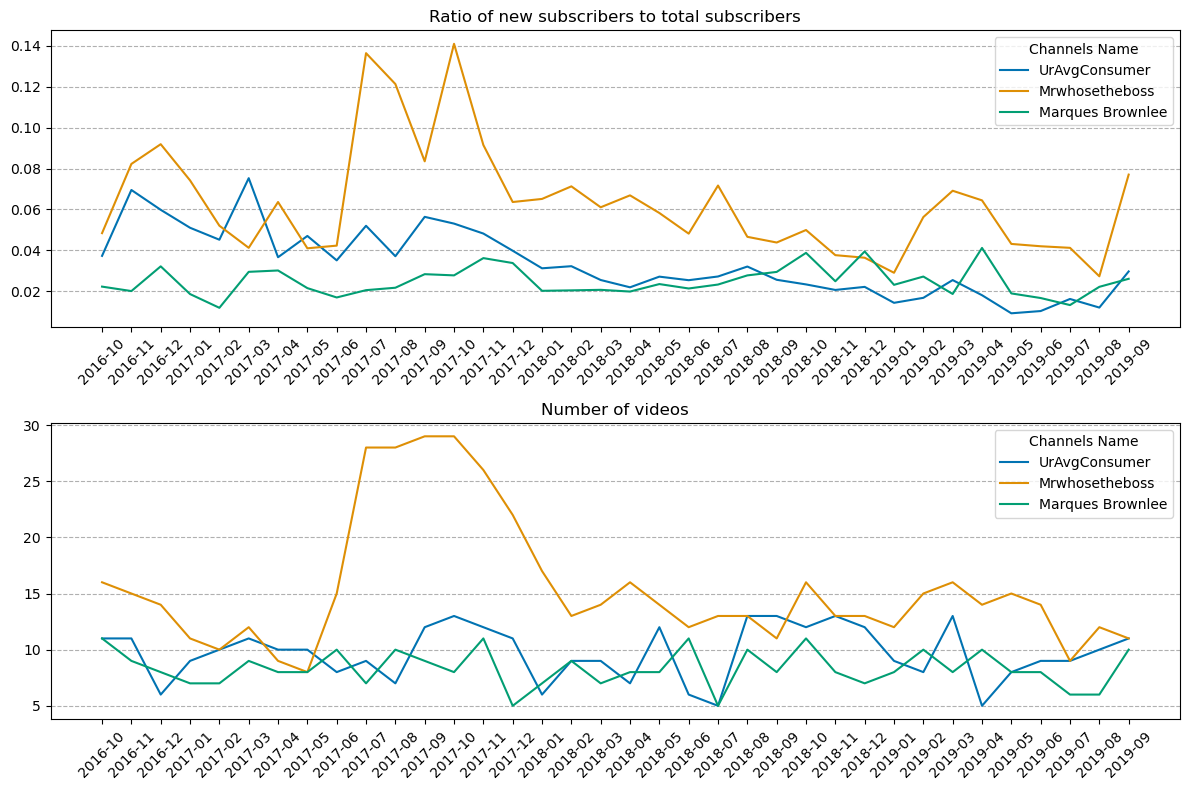

In [264]:
palette = sns.color_palette("Set2")
# Assuming the necessary dataframes are defined

colors = sns.color_palette("colorblind",3)
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

sns.lineplot(x=tech_3['date'],y=tech_3['delta_subs']/tech_3['subs'],hue=tech_3['channel_name'],ax=axs[0],palette=colors)
sns.lineplot(x=tech_3['date'],y=tech_3['n_videos'],hue=tech_3['channel_name'],ax=axs[1],palette=colors)

axs[0].set(title='Ratio of new subscribers to total subscribers', xlabel=None,ylabel=None)
axs[0].grid(axis='y', linestyle='--')
axs[0].tick_params(axis='x', rotation=45)
axs[0].legend(title='Channels Name')

axs[1].set(title='Number of videos', xlabel=None,ylabel=None)
axs[1].grid(axis='y', linestyle='--')
axs[1].tick_params(axis='x', rotation=45)
axs[1].legend(title='Channels Name')

plt.tight_layout()
plt.show()

Here even though it is mostly fluctuation, we can observe that some jumps in the number of videos is followed by the jumps in new subscribers. To be more sure about the correlation, we can also compute the spearman correlation, as the trends are not much linear:

In [265]:
print('Spearman correlation between Monthly number of videos and delta subscribers')
for channel_name in youtubers_list.values():
    corr = stats.spearmanr(tech_3[tech_3.channel_name==channel_name]["n_videos"], tech_3[tech_3.channel_name==channel_name]['delta_subs'])
    print('{channel}: {corr:.2f}, pvalue={pvalue:.2f}'.format(channel=channel_name,corr=corr.correlation,pvalue=corr.pvalue))


Marques Brownlee: 0.13, pvalue=0.46
UrAvgConsumer: 0.43, pvalue=0.01
Mrwhosetheboss: 0.22, pvalue=0.21


Here, we can see for 'UrAvgConsumer' a significant correlation is very clear, and also for the others, there is some correlation even though they are not significant.

Of course, the growth of a channel is not solely correlated with the frequency of releasing a video, but in this section we tried to analyse to what  extend they are correlated.

### Tech products range to review

In this section, we are going to analyze if covering a wider range of tech products is more effective to gain more subscribers, or should the channels focus on a specific type of tech.

Here, we are assessing 3 tech types, such as phone, camera, and laptop, and we are classifying videos into one of these 3 (or none), depending on some keywords that are relevant to these tech types. Then for each channel, we are calculating the percentage of camera, phone, and laptop videos:

In [13]:
# define some keywords for 3 categories of tech: laptop, phone, camera
keywords = {
    'laptop':['laptop','macbook','zenbook','vivobook','chromebook','aspire','inspiron','legion','macos','ram','cpu','monitor','keyboard','mouse','linux','windows'],
    'phone':['mobile','phone','smartphone','cellphone','verizon','iphone','android','galaxy','pixel','oneplus','ios','case','nexus','redmi','reno','nokia','htc','realme'],
    'camera':['camera','dslr','mirrorless','canon','nikon','sony','fujifilm','gopro','aperture','shutter','iso','tripod','lens','portrait']
}
tech_df_mt = df_tech_review_mt.copy()

# 2 videos are missing title, so we ignore them
tech_df_mt = tech_df_mt[tech_df_mt.title.notna()]

# classify the video into laptop, phone, camera
tech_df_mt['product_category'] = tech_df_mt.title.apply(lambda title: classify_product(title.lower(), keywords))

# all the videos are classified into 1 of the 3 categories, but just in case...
tech_df_prd = tech_df_mt[tech_df_mt.product_category.notna()]
print("Number of videos in metadata: ", tech_df_mt.shape[0])
print("Number of videos either about phone, laptop, or camera: ", tech_df_prd.shape[0])

# get the percentage of videos in 3 categories per channel
tech_df_prd_count = tech_df_prd.groupby(['channel_id','product_category'],as_index=False)[['display_id']].count().pivot(index='channel_id',columns='product_category',values='display_id').fillna(0)
tech_df_prd_perc = tech_df_prd_count.divide(tech_df_prd_count.sum(axis=1),axis=0)
display(tech_df_prd_perc.sample(5))

Number of videos in metadata:  740016
Number of videos either about phone, laptop, or camera:  380478


product_category,camera,laptop,phone
channel_id,,,
UCW6J17hZ_Vgr6cQgd_kHt5A,0.197970,0.258883,0.543147
UCark4B2q22cutojP6bzm2kQ,0.052632,0.631579,0.315789
UCsLNbGms_uWulcmbEqfZ_Pg,0.149254,0.492537,0.358209
UCnS-sZJLnwQhzfo7b8sxhTg,0.333333,0.190476,0.476190
UCQBX4JrB_BAlNjiEwo1hZ9Q,0.327945,0.087760,0.584296


Let's see in what categories more successful YouTubers tend to produce tech review videos by plotting the moving average (with window size of 50) of product type percentages over the rank of the YouTubers.

In [272]:
# define a new rank to the channels depending on its number of subscribers
df_tech_review_channels['new_rank'] = pd.Series(range(1, df_tech_review_channels.shape[0]+1))

# flag the channels with wide/narrow range of tech products to be used later
tech_df_prd_perc.loc[(tech_df_prd_perc['camera'] > 0.8) | (tech_df_prd_perc['laptop'] > 0.8) | (tech_df_prd_perc['phone'] > 0.8),'wide_range'] = False
tech_df_prd_perc['wide_range'].fillna(True, inplace=True)

# merge
channels_rank = pd.merge(df_tech_review_channels[['subscribers_cc','channel_id','new_rank']],tech_df_prd_perc,on='channel_id',how='right').sort_values(by='new_rank',ascending=True).reset_index(drop=True)


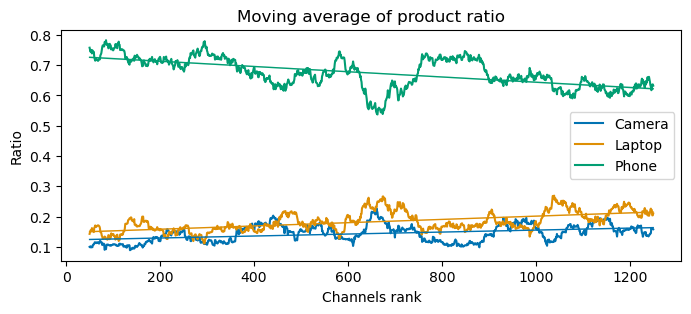

In [14]:
# define a new rank to the channels depending on its number of subscribers
df_tech_review_channels['new_rank'] = pd.Series(range(1, df_tech_review_channels.shape[0]+1))

# flag the channels with wide/narrow range of tech products to be used later
tech_df_prd_perc.loc[(tech_df_prd_perc['camera'] > 0.8) | (tech_df_prd_perc['laptop'] > 0.8) | (tech_df_prd_perc['phone'] > 0.8),'wide_range'] = False
tech_df_prd_perc['wide_range'].fillna(True, inplace=True)

# merge
channels_rank = pd.merge(df_tech_review_channels[['subscribers_cc','channel_id','new_rank']],tech_df_prd_perc,on='channel_id',how='right').sort_values(by='new_rank',ascending=True).reset_index(drop=True)

# moving average of category percentage per rank
colors = sns.color_palette("colorblind",3)
plt.figure(figsize=(8,3))

# plot moving average
ax = sns.lineplot(x=channels_rank['new_rank'], y=channels_rank['camera'].rolling(50).mean(), label='Camera',color=colors[0])
ax = sns.lineplot(x=channels_rank['new_rank'], y=channels_rank['laptop'].rolling(50).mean(), label='Laptop',color=colors[1])
ax = sns.lineplot(x=channels_rank['new_rank'], y=channels_rank['phone'].rolling(50).mean(), label='Phone', color=colors[2])

# Add regression lines
sns.regplot(x=channels_rank['new_rank'], y=channels_rank['camera'].rolling(50).mean(), scatter=False, ax=ax, color=colors[0], line_kws={'linewidth': 1})
sns.regplot(x=channels_rank['new_rank'], y=channels_rank['laptop'].rolling(50).mean(), scatter=False, ax=ax, color=colors[1], line_kws={'linewidth': 1})
sns.regplot(x=channels_rank['new_rank'], y=channels_rank['phone'].rolling(50).mean(), scatter=False, ax=ax, color=colors[2], line_kws={'linewidth': 1})

ax.set(title='Moving average of product ratio', xlabel='Channels rank', ylabel='Ratio')
plt.legend()
plt.show()


As we can see, most channels tend to focus on phones, and the higher the channels' rank, the more focus it has on a single product (in our case phones), and as the rank gets lower the ratio of products tend to get closer, meaning the channels are covering wider range of product types.

Below, we analyze the effect of covering wider/narrow range of products on the number of subscriber. But before that we want to balance the dataset on some metrics, namely average duration of videos per channel, and the delay in time between publishing 2 sequential videos. Below, we compute these metrices per video, and compute their micro averages.

In [273]:
# define average upload frequency per channel
tech_mt_uf = df_tech_review_mt.copy()
tech_mt_uf['upload_date'] = pd.to_datetime(tech_mt_uf.upload_date)
tech_mt_uf.sort_values(by=['channel_id','upload_date'],ascending=True,inplace=True)
tech_mt_uf['delay'] = tech_mt_uf.upload_date - tech_mt_uf.shift(1).upload_date
# set all first uploads to 0
first_upload = tech_mt_uf.groupby('channel_id',as_index=False)[['upload_date']].min()
first_upload['is_first'] = True
tech_df_upload_freq = pd.merge(tech_mt_uf,first_upload,on=['channel_id','upload_date'],how='left')
tech_df_upload_freq.is_first.fillna(False,inplace=True)
tech_df_upload_freq.loc[tech_df_upload_freq.is_first,'delay'] = pd.Timedelta(seconds=0)
tech_df_upload_freq['upload_year'] = tech_df_upload_freq.upload_date.dt.year
tech_df_upload_freq['upload_month'] = tech_df_upload_freq.upload_date.dt.month
tech_df_avg = tech_df_upload_freq.groupby(['channel_id','upload_year','upload_month'],as_index=False)[['delay']].mean().groupby(['channel_id','upload_year'],as_index=False)[['delay']].mean().groupby(['channel_id'],as_index=False)[['delay']].mean()
tech_df_avg.rename({'delay':'avg_delay'},axis=1,inplace=True)
tech_df_avg.avg_delay = (tech_df_avg.avg_delay / np.timedelta64(1, 'D')).astype(float)

# define average duration
tech_df_avg_dur = tech_df_upload_freq.groupby(['channel_id','upload_year','upload_month'],as_index=False)[['duration']].mean().groupby(['channel_id','upload_year'],as_index=False)[['duration']].mean().groupby(['channel_id'],as_index=False)[['duration']].mean()
tech_df_avg_dur.rename({'duration':'avg_duration'},axis=1,inplace=True)

# define dataframe for observational study
df_obs = pd.merge(df_tech_review_channels[['channel_id','subscribers_cc']],tech_df_avg_dur,on='channel_id',how='left')
df_obs = pd.merge(df_obs,tech_df_avg,on='channel_id',how='left')
df_obs = pd.merge(df_obs,channels_rank[['channel_id','wide_range','new_rank']],on='channel_id',how='right')
df_obs.loc[df_obs['wide_range'],'wide_range'] = 1
df_obs.loc[df_obs['wide_range'] != 1,'wide_range'] = 0
df_obs['wide_range'] = df_obs['wide_range'].astype(int)
display(df_obs.sample(5))

,channel_id,subscribers_cc,avg_duration,avg_delay,wide_range,new_rank
1042,UChWHCJy_4sjmLgs04DHS6og,17700,896.732639,10.815972,0,1056
127,UCdOW3cPYnZhQK-0AnjF6bmw,492000,431.717082,10.469757,1,128
864,UCIeB9FHiEx9dTRquXaOkIHQ,29500,306.145440,17.883614,0,877
1148,UCzQLVOpDfxyvq1zAujU10xw,12500,287.061508,24.890278,1,1163
847,UC_acrluhgPmor082TT3lhDA,28300,368.502518,21.278931,1,859


Here we plot some statistics of average delay and average duration of videos, and the number of subscribers distribution. Because both groups are already pretty much balanced we did not further balance the dataset using the propensity score.

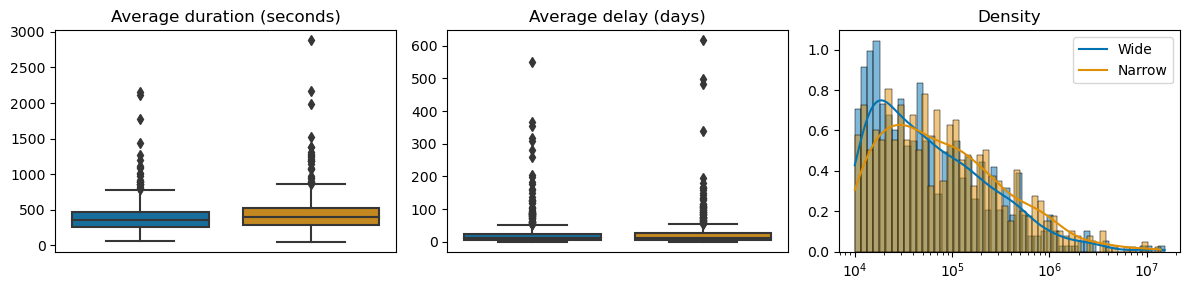

In [280]:
colors = sns.color_palette("colorblind",2)
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(12,3))

# plot
sns.boxplot(y=df_obs['avg_duration'],x=df_obs['wide_range'],ax=axes[0],palette=colors)
sns.boxplot(y=df_obs['avg_delay'],x=df_obs['wide_range'],ax=axes[1],palette=colors)
sns.histplot(df_obs[df_obs['wide_range'] == 1]['subscribers_cc'],stat='density',kde=True,bins=50,log_scale=(True,False),ax=axes[2],color=colors[0])
sns.histplot(df_obs[df_obs['wide_range'] == 0]['subscribers_cc'],stat='density',kde=True,bins=50,log_scale=(True,False),ax=axes[2],color=colors[1])

axes[0].set(title='Average duration (seconds)',xlabel=None,ylabel=None,xticks=[])
axes[1].set(title='Average delay (days)',xlabel=None,ylabel=None,xticks=[])
axes[2].set(title='Density',xlabel=None,ylabel=None)
axes[2].legend(['Wide','Narrow'])

plt.tight_layout()
plt.show()

The distribution of the Wide and Narrow channels shows us that the channels with narrow focus on a particular tech product is almost always domonating (especially as the number of subscribers get higher).

# Viewers reaction to big tech product releases

There are various major tech events happening throughout the year, and of course the products released in these events are a great chance for the YouTubers to attract new viewers. In this notebook we are going to analyze the period of release of iPhone X, and see how the viewers reacted to those videos.

In [36]:
# define the release date of iphone x
item = 'iphone x'
release_date = {'iphone x': pd.to_datetime('2017-11-03')}

Below we are getting the daily total number of views from the raw dataset, and finding the ratio of daily sum of views of videos about iphone x to the total views, and plotting the trend over time within 6 months of iphone x release.

Number of videos about Iphone X within 6 month of its release: 2820


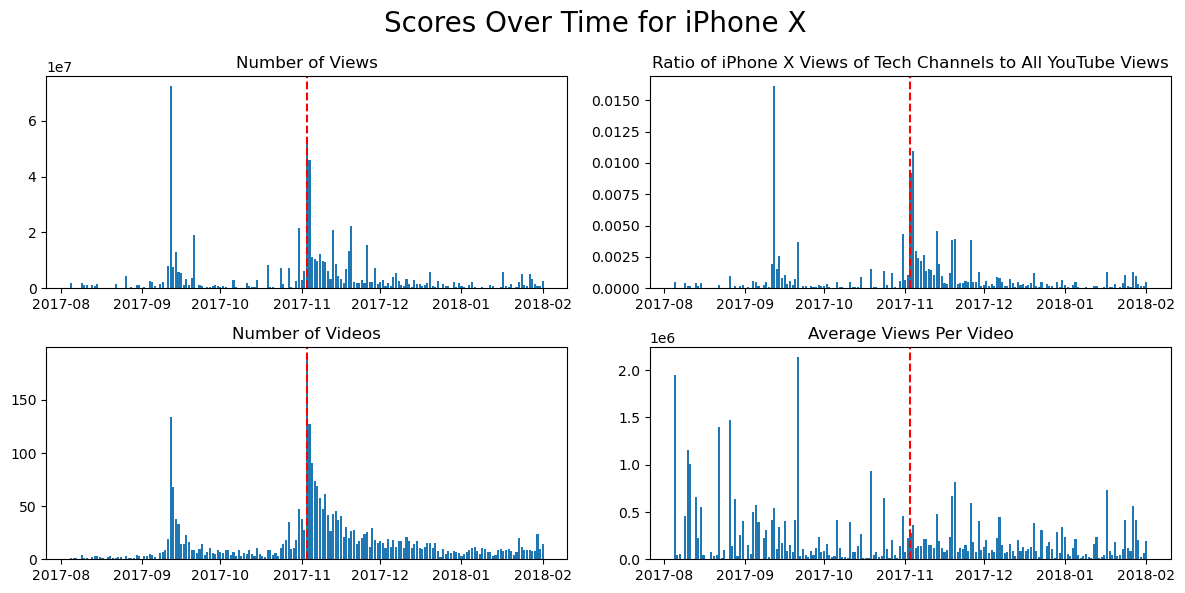

In [281]:
# 2 videos are missing title, so we ignore them
df_tech_review_mt = df_tech_review_mt[df_tech_review_mt.title.notna()]
# get only the iphone x videos
iphone_df = df_tech_review_mt[df_tech_review_mt['title'].str.lower().str.contains(item)].copy()

# from the raw dataset, we want to get the number of total views on all YouTube videos per day
yt_date_views = {}
total_rows = 72924794
chunksize = 100000
for df_json in tqdm(pd.read_json(PATH_YT_METADATA, compression="infer", lines=True, chunksize=chunksize), desc='Loading data', total=total_rows/chunksize):
    df_json.drop(["description", "crawl_date", "display_id", "tags", "categories"], inplace=True, axis=1)

    df_json["upload_date"] = pd.to_datetime(df_json["upload_date"])
    df_json = df_json[(df_json['upload_date'] >= release_date[item] - datetime.timedelta(days=90)) & ((df_json['upload_date'] <= release_date[item] + datetime.timedelta(days=90)))]

    # get the daily sum of view counts
    youtube_views = get_sum_views(df_json)

    # for each 'upload_date, get the corresponding 'view_count' in youtube_views
    for date in youtube_views.index:
        if date in yt_date_views:
            yt_date_views[date] += youtube_views.loc[date]["view_count"]
        else:
            yt_date_views[date] = youtube_views.loc[date]["view_count"]

# 2 dataframes corresponding to number of views of all videos and the ones about iphone x per day
yt_date_views_df = pd.DataFrame.from_dict(yt_date_views, orient="index", columns=["view_count"])
iphone_date_views_df = get_sum_views(iphone_df)

# merge dataframes on the 'upload_date' column and get the ratio
merged_df = pd.merge(yt_date_views_df, iphone_date_views_df, left_index=True, right_index=True)
merged_df = merged_df.rename(columns={"view_count_x": "youtube_view_count", "view_count_y": "iphone_view_count"})
merged_df["ratio"] = merged_df["iphone_view_count"] / merged_df["youtube_view_count"]

# get some metrics of iphone x videos per day
df_score = score_per_day(iphone_df, 'iphone x', release_date[item])
print('Number of videos about Iphone X within 6 month of its release:', df_score.title.sum())

# plot the 4 curves in 4 subplots as bar graphs and for each subplot put a vertical dotted line at the release date
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))
axs[0][0].bar(df_score.index, df_score["view_count"])
axs[0][0].set_title("Number of Views")
axs[0][0].axvline(x=release_date[item], color="red", linestyle="--")

axs[0][1].bar(merged_df.index, merged_df["ratio"])
axs[0][1].set_title("Ratio of iPhone X Views of Tech Channels to All YouTube Views")
axs[0][1].axvline(x=release_date[item], color="red", linestyle="--")

axs[1][0].bar(df_score.index, df_score["title"])
axs[1][0].set_title("Number of Videos")
axs[1][0].axvline(x=release_date[item], color="red", linestyle="--")

axs[1][1].bar(df_score.index, df_score["view_count"] / df_score["title"])
axs[1][1].set_title("Average Views Per Video")
axs[1][1].axvline(x=release_date[item], color="red", linestyle="--")

# give a big title to the entire figure
fig.suptitle("Scores Over Time for {product_name}".format(product_name='iPhone X'), fontsize=20)
plt.tight_layout()
plt.show()

As we can see from the above plots, September 2017 and November 2017 are all months with very high user interaction with videos about the iPhone. We can also clearly see that the number of views and videos released about the iPhone X reach peaks in September and November 2017. September 2017 is the month where iPhone X was announced and November 2017 is the month where the iPhone X was released.

It is also interesting to see the ratio of videos by tech youtubers to all videos. The fact that it reached 1.5% means during theses periods the tech youtubers have chance to attract viewers from other categories as well.

We can see the Youtube platform is most active around one month before the release of a product and at the time of its release. We can also further analyse is for other major tech events to come to some conclusion.

Having seen this, we would like to know what topics are the most discussed in the videos about the iPhone. during these two periods.

In [22]:
iphone_df["upload_date"] = pd.to_datetime(iphone_df["upload_date"])

# divide the video release date into 2 part (pre, during)
pre_release = iphone_df[(iphone_df["upload_date"] <= release_date['iphone x'] - datetime.timedelta(days=30)) & (iphone_df["upload_date"] >= release_date['iphone x'] - datetime.timedelta(days=90))]
release = iphone_df[(iphone_df["upload_date"] >= release_date['iphone x'] - datetime.timedelta(days=30)) & (iphone_df["upload_date"] <= release_date['iphone x'] + datetime.timedelta(days=30))]

# keep only top 30% most viewed videos
pre_release = pre_release.sort_values(by="view_count", ascending=False)
pre_release = pre_release.iloc[:int(len(pre_release) * 0.3)]
release = release.sort_values(by="view_count", ascending=False)
release = release.iloc[:int(len(release) * 0.3)]

In [41]:
print('Pre-release topics: ')
pre_release_topics = get_lda_topics(pre_release, 3, 10)

Pre-release topics: 
Topic 1: apple, new, face, event, cnet, hand, news, best, everything, comparison
Topic 2: plus, apple, galaxy, samsung, note, hand, leak, talk, tech, camera
Topic 3: buy, galaxy, reason, plus, note, get, one, know, thing, phone


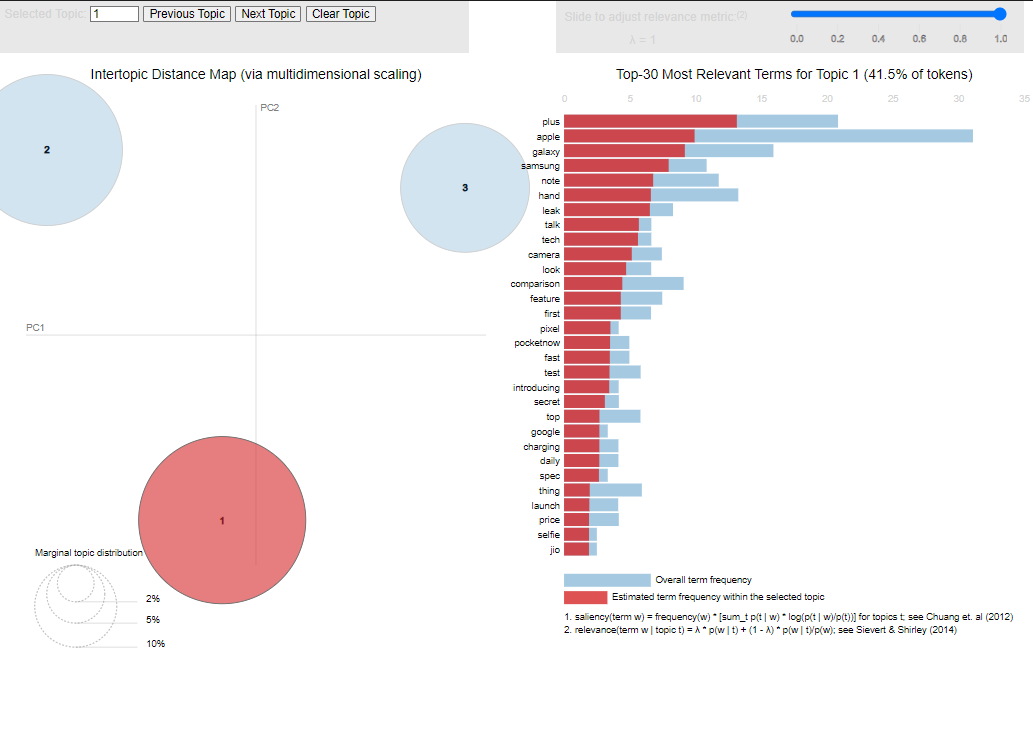

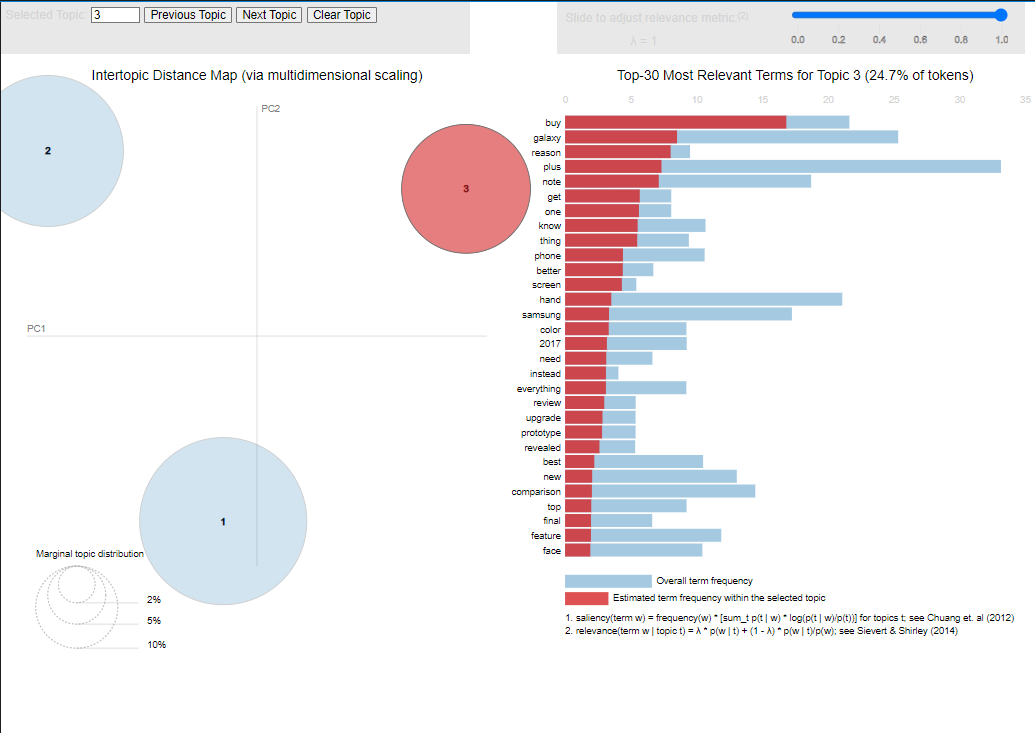

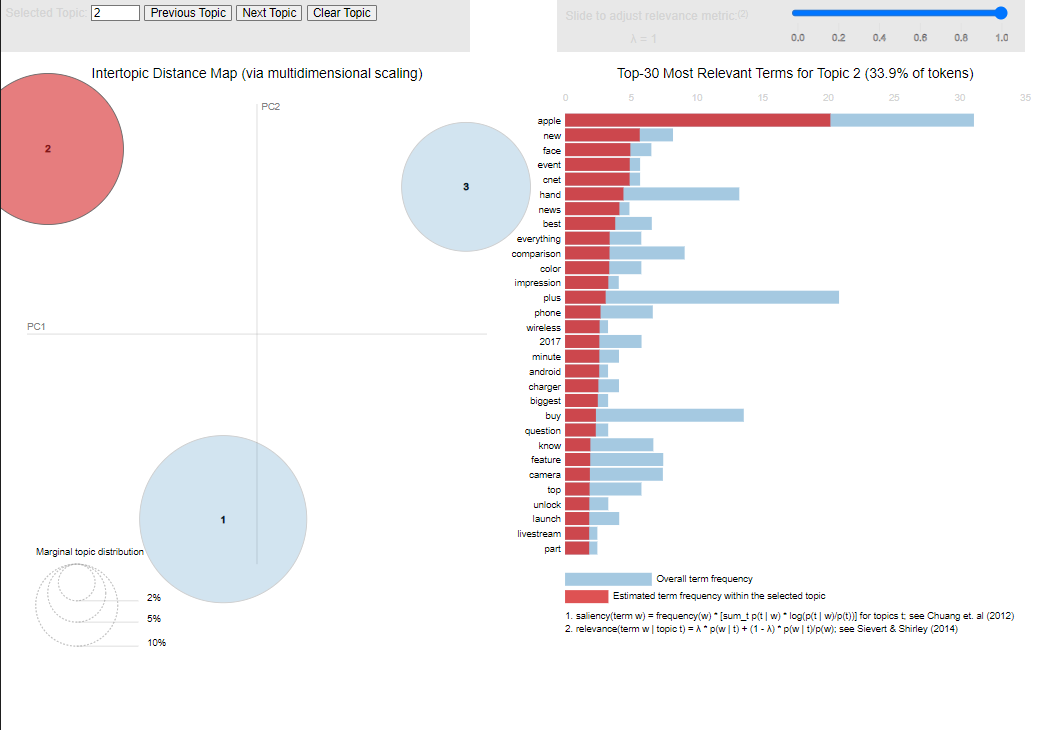

In [287]:
# Display the 3 topics of pre release period
image_paths = [
    '.\\figures\\pre_release_1.png',
    '.\\figures\\pre_release_2.png',
    '.\\figures\\pre_release_3.png'
]

for image_path in image_paths:
    img = PILImage.open(image_path)
    display(Image(filename=image_path))


In [42]:
print('During-release topics: ')
release_topics = get_lda_topics(release, 3, 10)

During-release topics: 
Topic 1: review, case, test, apple, camera, plus, speed, galaxy, best, samsung
Topic 2: unboxing, apple, first, camera, daily, pocketnow, comparison, feature, setup, review
Topic 3: test, speed, apple, note, galaxy, comparison, pixel, camera, tip, drop


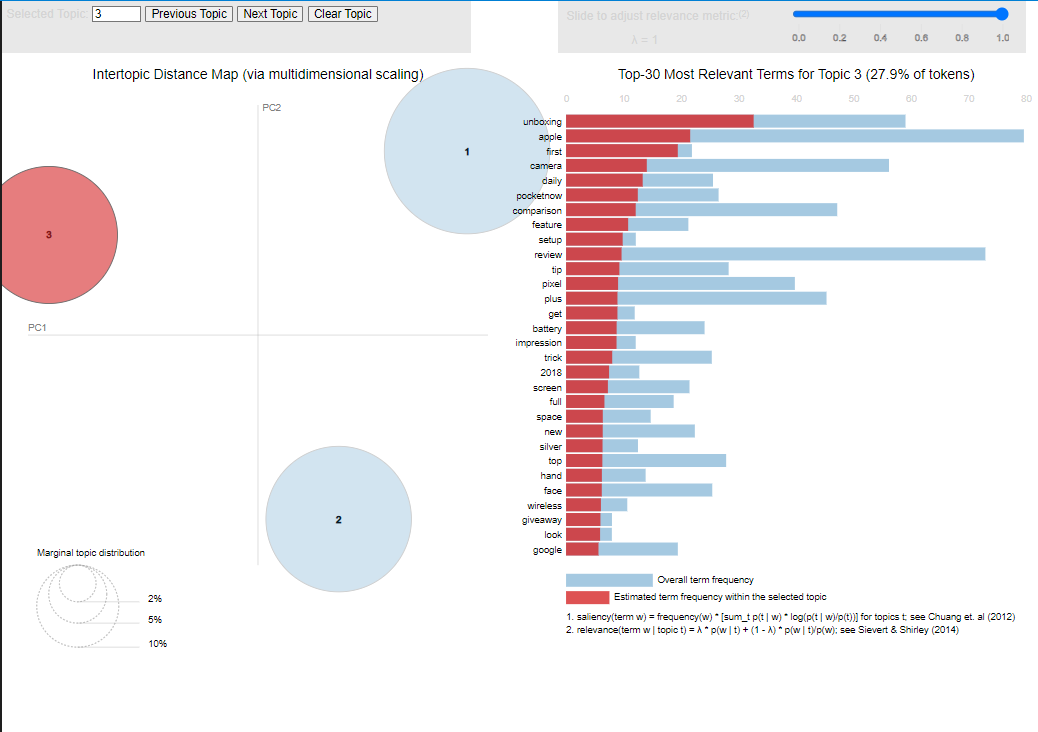

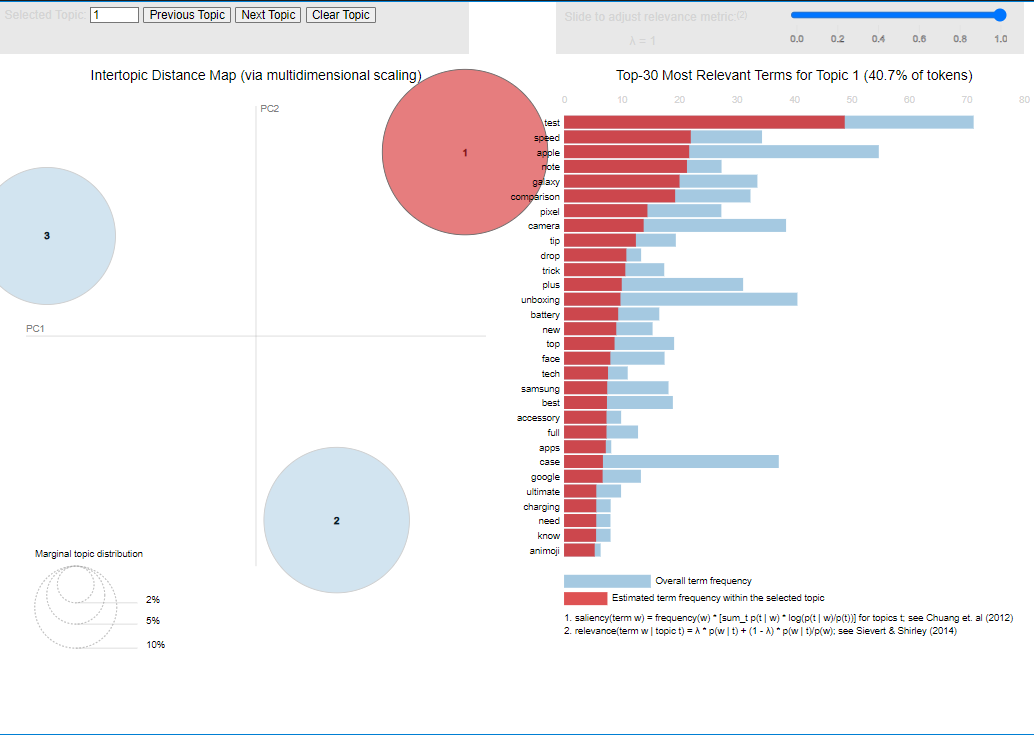

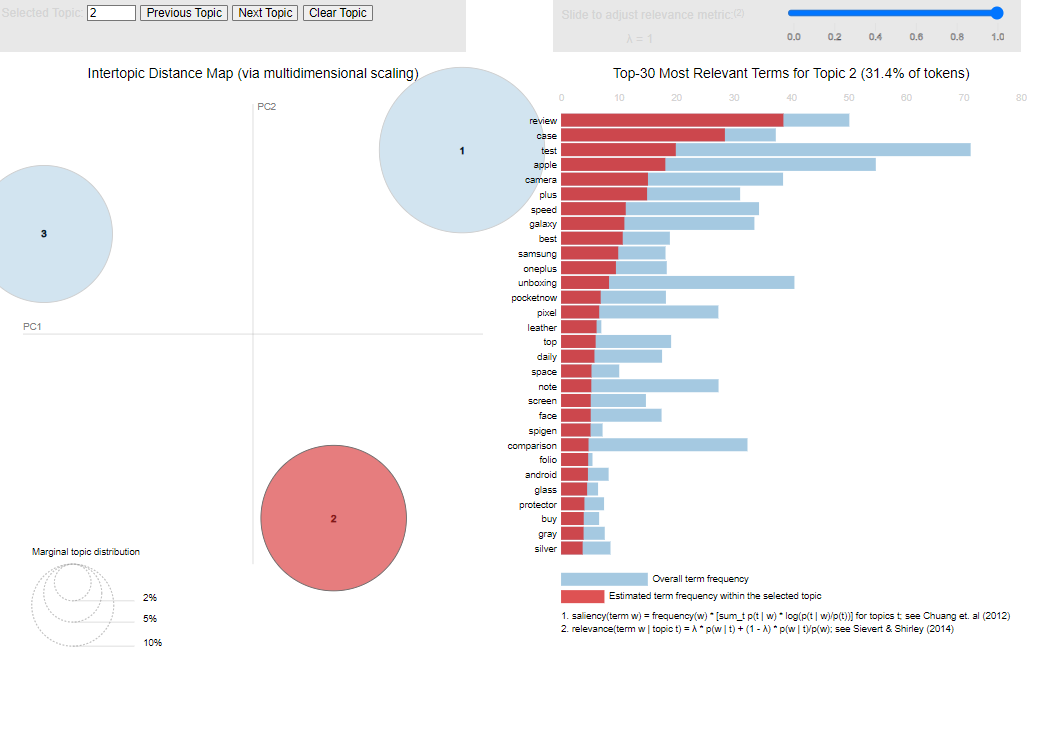

In [289]:
# Display the 3 topics of pre release period
image_paths = [
    '.\\figures\\release_1.png',
    '.\\figures\\release_2.png',
    '.\\figures\\release_3.png'
]

for image_path in image_paths:
    img = PILImage.open(image_path)
    display(Image(filename=image_path))

As we can see, topics discussed in the pre-release period and during the release period are very different.
In pre-release period, the videos mostly talk about:
- Leaking information about the iPhone X
- Unboxing of clones or possible prototypes of the iPhone X
- Possible features of the iPhone X

And during the release period, the videos mostly talk about:
- Unboxing of the iPhone X
- Reviews of the iPhone X
- Comparisons between the iPhone X and other phones
- Testing different features of the iPhone X such as the camera, the screen, the battery, etc.